Author: Joshua, Will, Ethan <br />
Summary: Makes a coverage matrix {0,1} if an ambulance station covers a region

In [1]:
import csv
import collections
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

In [2]:
# This is the grid object, which is used throughout all data preprocessing.
# It represents the city of Austin through a series of grids.
# It thus makes a tractable way to compute distance between grids, ect. 
class Grid():
    def __init__(self, grid_json):
        self.grid = grid_json
        self.min_lat = self.grid["latitude_min"]
        self.min_lon = self.grid["longitude_min"]
        self.max_lat = self.grid["latitude_max"]
        self.max_lon = self.grid["longitude_max"]
        self.latitude_delta = self.grid["latitude_step"]
        self.longitude_delta = self.grid["longitude_step"]
        self.nrows = math.ceil((self.max_lat - self.min_lat) / self.latitude_delta)
        self.ncols = math.ceil((self.max_lon - self.min_lon) / self.longitude_delta)
        self.times = self.grid["time_matrix"]
        self.census_tract_region_map = self.grid["census_tract_region_mapping"]
        self.region_to_tract = collections.defaultdict(list)
        for census_tract in self.census_tract_region_map:
            for region in self.census_tract_region_map[census_tract]:
                self.region_to_tract[region].append(census_tract)
    def map_point_to_region(self, latitude, longitude):
        return math.floor((latitude-self.min_lat)/self.latitude_delta) * self.ncols  + math.floor((longitude-self.min_lon)/self.longitude_delta)
    def get_representative(self, region_num):
        row_num = region_num//self.ncols
        col_num = region_num - row_num*self.ncols
        lat = self.min_lat + row_num * self.latitude_delta + 0.5*self.latitude_delta
        lon = self.min_lon + col_num * self.longitude_delta + 0.5*self.longitude_delta
        return [lon, lat]
    def get_time(self, region1, region2):
        try:
            return self.times[region1][region2]
        except IndexError:
            return -1
    def region_to_census_tract(self, region):
        try:
            return self.region_to_tract[region]
        except KeyError:
            return "0_0"

In [3]:
# Using smaller distance matrix for hopefully faster runtime of Julia code
with open("Input_Data/grid_info_smaller.json", "r") as f:
    grid_json = json.load(f)

In [4]:
g = Grid(grid_json)

stations = pd.read_csv("Austin_Data/stations.csv")

#stations = stations[stations["FACILITY_TYPE"].str.contains("Medic Station")]

numstations = stations["LATITUDE"].size # Should be 51
numregions = g.nrows * g.ncols

coverage_times = np.zeros(shape=(numstations, numregions))
coverage = np.zeros(shape=(numstations, numregions))
numstations

44

In [5]:
region_numbers = range(1, numregions + 1)

station_numbers = ["".join(["x", str(i)]) for i in range(1, numstations + 1)]

coverage = pd.DataFrame(data=coverage, index=station_numbers, columns=region_numbers)
coverage_times = pd.DataFrame(data=coverage_times, index=station_numbers, columns=region_numbers)

In [30]:
max_travel_time = 60*15 #grid time get time is in seconds. So the threshhold is 15 minutes times 60 seconds

#make 0 if travel time is greater than shortfall time
#travel time is none
#travel time = 0 and not at yourself location
for station in range(0, numstations):
    region_of_station = g.map_point_to_region(stations["LATITUDE"][station], stations["LONGITUDE"][station])
    for region in range(0, numregions):
        travel_time = g.get_time(region_of_station, region)
        
        # travel_times[station][region] = travel_time
        # covered if <= 600 seconds = 10 minutes
        # not covered if >= 600 seconds, not reachable (travel_time is None), 
        #    or invalid region (travel_time == 0 and region_of_station != region)
        coverage.at["x"+str(station+1), region+1] = (0 if (travel_time is None 
                                                           or travel_time > max_travel_time 
                                                           or (travel_time == 0 and region_of_station != region)) 
                                          else 1)  
coverage

,1,2,3,4,5,6,7,8,9,10,...,201,202,203,204,205,206,207,208,209,210
x1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


798.0

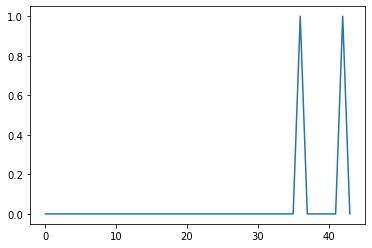

In [31]:
coverage_np = coverage.to_numpy()
plt.plot(coverage_np[:,55])
sum(sum(coverage_np))

## Make all regions with no coverage fully covered (why?)

In [32]:
for col in coverage:
    print(col, sum(coverage[col]))
    if sum(coverage[col]) == 0:
        coverage[col] += 1
        print("\t->", sum(coverage[col]))

1 0.0
	-> 44.0
2 0.0
	-> 44.0
3 0.0
	-> 44.0
4 0.0
	-> 44.0
5 0.0
	-> 44.0
6 0.0
	-> 44.0
7 0.0
	-> 44.0
8 1.0
9 2.0
10 0.0
	-> 44.0
11 0.0
	-> 44.0
12 0.0
	-> 44.0
13 0.0
	-> 44.0
14 0.0
	-> 44.0
15 0.0
	-> 44.0
16 0.0
	-> 44.0
17 0.0
	-> 44.0
18 0.0
	-> 44.0
19 0.0
	-> 44.0
20 1.0
21 1.0
22 3.0
23 2.0
24 3.0
25 1.0
26 1.0
27 0.0
	-> 44.0
28 0.0
	-> 44.0
29 0.0
	-> 44.0
30 0.0
	-> 44.0
31 0.0
	-> 44.0
32 0.0
	-> 44.0
33 0.0
	-> 44.0
34 0.0
	-> 44.0
35 0.0
	-> 44.0
36 5.0
37 4.0
38 4.0
39 4.0
40 1.0
41 1.0
42 1.0
43 0.0
	-> 44.0
44 0.0
	-> 44.0
45 0.0
	-> 44.0
46 0.0
	-> 44.0
47 0.0
	-> 44.0
48 0.0
	-> 44.0
49 0.0
	-> 44.0
50 2.0
51 2.0
52 4.0
53 5.0
54 3.0
55 7.0
56 2.0
57 2.0
58 0.0
	-> 44.0
59 0.0
	-> 44.0
60 0.0
	-> 44.0
61 0.0
	-> 44.0
62 0.0
	-> 44.0
63 0.0
	-> 44.0
64 1.0
65 2.0
66 6.0
67 10.0
68 17.0
69 7.0
70 6.0
71 0.0
	-> 44.0
72 0.0
	-> 44.0
73 0.0
	-> 44.0
74 0.0
	-> 44.0
75 0.0
	-> 44.0
76 0.0
	-> 44.0
77 0.0
	-> 44.0
78 0.0
	-> 44.0
79 0.0
	-> 44.0
80 2.0
81 1.0
82 10.0


In [33]:
coverage.to_csv("Output_Data/coverage.csv")
coverage.transpose()
coverage
# travel_times.to_csv("coverage_times.csv")

,1,2,3,4,5,6,7,8,9,10,...,201,202,203,204,205,206,207,208,209,210
x1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
x10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [34]:
#sanity check
for index, row in coverage.iterrows():
    if sum(row) == 0:
        print("NO COVERAGE: (region#: ", index, "), ", "(census tract: ", g.region_to_census_tract(index), "), ", g.get_representative(index))
    

In [35]:
coverage.to_csv("Austin_data/coverage_real.csv", header=None, index=False)